# Feature Engineering Code-along Solution

<a href="https://colab.research.google.com/github/coding-dojo-data-science/week-10-lecture-2-feature-engineering/blob/11-7-22/SOLUTION%20Challenge%20Feature%20Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In this notebook we use the following feature engineering strategies:
1. scaling
2. binning
3. removing outliers
4. log transformation
5. target encoding
6. polynomial features

In [98]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, \
precision_score, recall_score, accuracy_score, f1_score, ConfusionMatrixDisplay, \
classification_report

import warnings
warnings.filterwarnings('ignore')

# Useful Functions

In [99]:
def eval_regression(true, pred, name='Model'):
    """Evaluates true and predicted values from a regression model.  
    Outputs a dataframe of metrics"""
    scores = pd.DataFrame()
    scores['Model Name'] = [name]
    scores['RMSE'] = [np.sqrt(mean_squared_error(true, pred))]
    scores['MAE'] = [mean_absolute_error(true, pred)]
    scores['R2'] = [r2_score(true, pred)]
    scores.set_index('Model Name', inplace=True)

    return scores

def eval_classification(true, pred, name='Model'):
    """shows classification_report and confusion matrix
    for classification model predictions.  Outputs a dataframe of metrics"""
  
    print(name, '\n')
    print(classification_report(true, pred))
    ConfusionMatrixDisplay.from_predictions(true, pred)
    plt.show()

    scores = pd.DataFrame()
    scores['Model Name'] = [name]
    scores['Precision'] = [precision_score(true, pred)]
    scores['Recall'] = [recall_score(true, pred)]
    scores['F1 Score'] = [f1_score(true, pred)]
    scores['Accuracy'] = [accuracy_score(true, pred)]
    scores.set_index('Model Name', inplace=True)

    return scores

## Data

Today we will use data about used car sales in India from Kaggle.  [Here is the source](https://www.kaggle.com/datasets/saisaathvik/used-cars-dataset-from-cardekhocom)

In [100]:
# load data
df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vTeFV8-y5rNxCM946otPPyTF5UZ5rIOTOHrXCYU5zkqB7DubjxGKGzaxVayeLdU0wcCqLMrhjUbgkEp/pub?gid=1641648108&single=true&output=csv')
df_backup = df.copy()

display(df.head())
print(df.shape)

,Id,year,brand,full_model_name,model_name,price,distance_travelled(kms),fuel_type,city
0,0,2016,Honda,Honda Brio S MT,Brio,425000,9680,Petrol,Mumbai
1,1,2012,Nissan,Nissan Sunny XV Diesel,Sunny,325000,119120,Diesel,Mumbai
2,2,2017,Toyota,Toyota Fortuner 2.8 4x2 MT [2016-2020],Fortuner,2650000,64593,Diesel,Thane
3,3,2017,Mercedes-Benz,Mercedes-Benz E-Class E 220d Expression [2019-...,E-Class,4195000,25000,Diesel,Mumbai
4,4,2012,Hyundai,Hyundai Verna Fluidic 1.6 CRDi SX,Verna,475000,23800,Diesel,Mumbai


(1725, 9)


## Explore and clean the data

In [101]:
# drop 'Id' column
df.drop(columns='Id', inplace=True)
df.head()

,year,brand,full_model_name,model_name,price,distance_travelled(kms),fuel_type,city
0,2016,Honda,Honda Brio S MT,Brio,425000,9680,Petrol,Mumbai
1,2012,Nissan,Nissan Sunny XV Diesel,Sunny,325000,119120,Diesel,Mumbai
2,2017,Toyota,Toyota Fortuner 2.8 4x2 MT [2016-2020],Fortuner,2650000,64593,Diesel,Thane
3,2017,Mercedes-Benz,Mercedes-Benz E-Class E 220d Expression [2019-...,E-Class,4195000,25000,Diesel,Mumbai
4,2012,Hyundai,Hyundai Verna Fluidic 1.6 CRDi SX,Verna,475000,23800,Diesel,Mumbai


In [102]:
# check for duplicates
df.duplicated().sum()

425

In [103]:
# remove duplicates
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [104]:
# check for missing values
df.isna().sum()

year                       0
brand                      0
full_model_name            0
model_name                 0
price                      0
distance_travelled(kms)    0
fuel_type                  0
city                       0
dtype: int64

In [105]:
# check summary statistics
df.describe(include='all')

,year,brand,full_model_name,model_name,price,distance_travelled(kms),fuel_type,city
count,1300.000000,1300,1300,1300,1.300000e+03,1300.000000,1300,1300
unique,NaN,31,750,168,NaN,NaN,5,15
top,NaN,Maruti Suzuki,Volkswagen Polo GT TSI,Creta,NaN,NaN,Diesel,Hyderabad
freq,NaN,222,9,56,NaN,NaN,688,238
mean,2015.260000,NaN,NaN,NaN,1.479683e+06,55235.615385,NaN,NaN
std,3.248511,NaN,NaN,NaN,1.720193e+06,47298.039050,NaN,NaN
min,1990.000000,NaN,NaN,NaN,6.250000e+04,350.000000,NaN,NaN
25%,2013.000000,NaN,NaN,NaN,5.250000e+05,30000.000000,NaN,NaN
50%,2016.000000,NaN,NaN,NaN,8.425000e+05,50227.000000,NaN,NaN
75%,2018.000000,NaN,NaN,NaN,1.796250e+06,72000.000000,NaN,NaN


## Some Numeric Feature Engineering


 year 



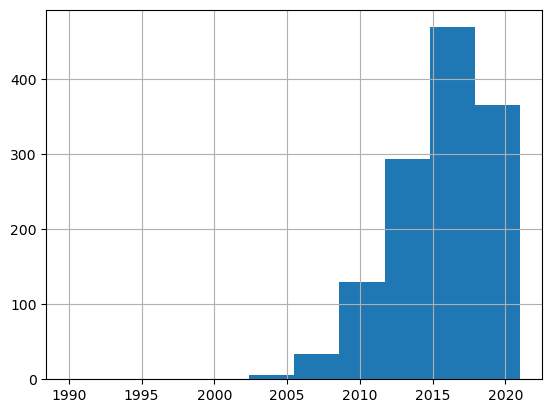


 price 



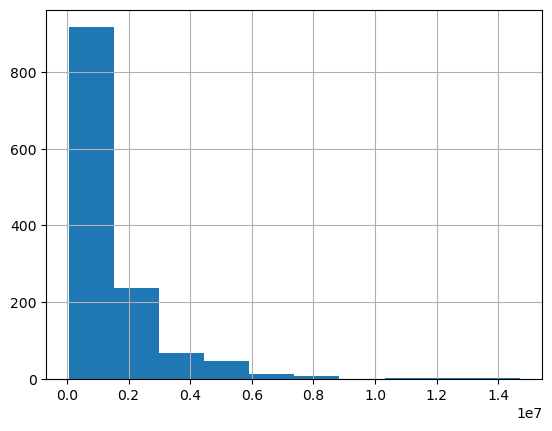


 distance_travelled(kms) 



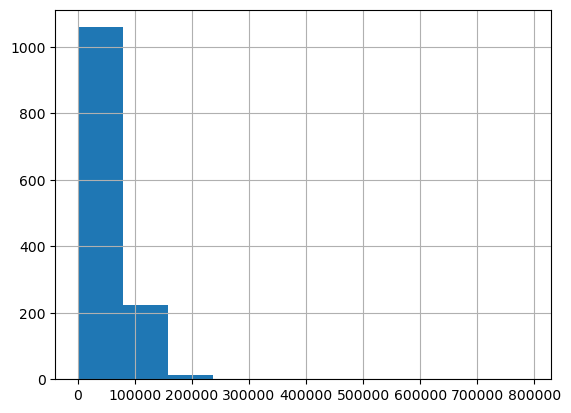

In [106]:
# explore numeric distributions
for col in df.select_dtypes('number'):
  print('\n', col, '\n')
  df[col].hist()
  plt.show()

### Filter to remove outliers

In [107]:
df['year'].value_counts().sort_index()

1990      1
2004      2
2005      4
2006      3
2007     11
2008     20
2009     25
2010     44
2011     61
2012    101
2013     81
2014    112
2015    141
2016    161
2017    167
2018    178
2019    114
2020     58
2021     16
Name: year, dtype: int64

In [108]:
# exclude cars made before 2000
df = df[df['year'] > 2000]
df['year'].value_counts()

2018    178
2017    167
2016    161
2015    141
2019    114
2014    112
2012    101
2013     81
2011     61
2020     58
2010     44
2009     25
2008     20
2021     16
2007     11
2005      4
2006      3
2004      2
Name: year, dtype: int64

## Convert year to nominal categorical

This way, if cars made in certain years are more expensive than those made in other years, the model can see this in a non-linear way.

In [109]:
# convert year to categorical
df['year'] = df['year'].astype('object')

## Transform to normalize feature

<AxesSubplot: >

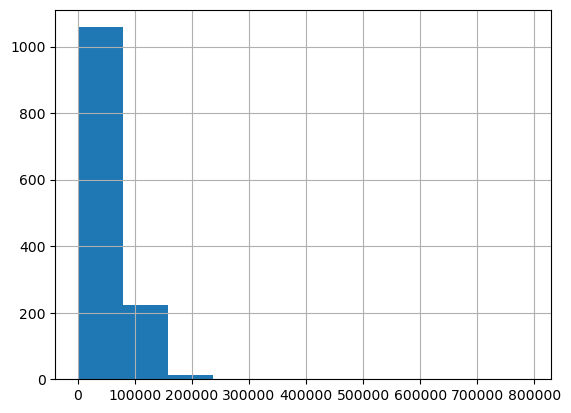

In [110]:
df['distance_travelled(kms)'].hist()

<AxesSubplot: >

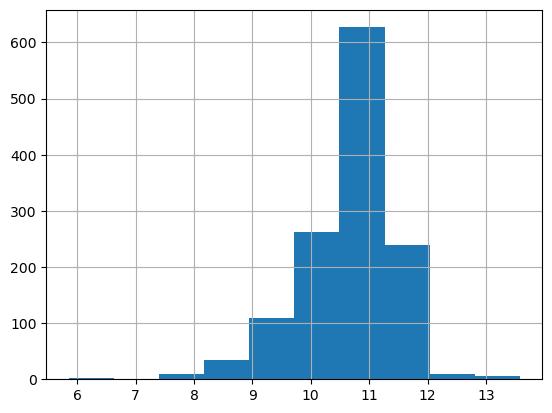

In [111]:
# log transform 'distance_travelled(kms)'
df['distance_travelled(kms)'] = np.log(df['distance_travelled(kms)'])

df['distance_travelled(kms)'].hist()

## Binning the Target: Let's change this regression problem to a binary classification problem

In [112]:
df['price'].describe()

count    1.299000e+03
mean     1.480572e+06
std      1.720557e+06
min      6.250000e+04
25%      5.250000e+05
50%      8.500000e+05
75%      1.797500e+06
max      1.470000e+07
Name: price, dtype: float64

#### What's wrong with the code below?  How would you fix it?

In [113]:
# encode cars with prices above the mean as 1 and below the mean as 0

df['is_expensive'] = df['price'].apply(lambda x: 1 if x > df['price'].mean() else 0)
df['is_expensive'].value_counts()

0    909
1    390
Name: is_expensive, dtype: int64

In [114]:
X = df.drop(columns=['price', 'is_expensive'])
y = df['price']

X_train, X_test, y_train, y_test =  train_test_split(X, y, random_state=42)

# Bin the Target

In [115]:
df['price'].head()

0     425000
1     325000
2    2650000
3    4195000
4     475000
Name: price, dtype: int64

In [116]:
mean_price = y_train.mean()
y_train = y_train.apply(lambda x: 1 if x > mean_price else 0)
y_test = y_test.apply(lambda x: 1 if x > mean_price else 0)

In [117]:
y_train.value_counts()

0    681
1    293
Name: price, dtype: int64

# Base Model

In [118]:
# instantiate transformers
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

cat_cols = make_column_selector(dtype_include='object')
num_cols = make_column_selector(dtype_include='number')

# create preprocessing pipeline
base_preprocess = make_column_transformer((ohe, cat_cols), (scaler, num_cols))

# Examine the results of all transformers
base_preprocess.fit_transform(X_train, y_train).shape

(974, 836)

In [119]:
# Create and evaluate model with a base logistic regression
logreg_base = LogisticRegression(max_iter=1000)
logreg_base = make_pipeline(base_preprocess, logreg_base)
logreg_base.fit(X_train, y_train)

train_pred = logreg_base.predict(X_train)
test_pred = logreg_base.predict(X_test)

BaseTrain 

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       681
           1       0.97      0.97      0.97       293

    accuracy                           0.98       974
   macro avg       0.98      0.98      0.98       974
weighted avg       0.98      0.98      0.98       974



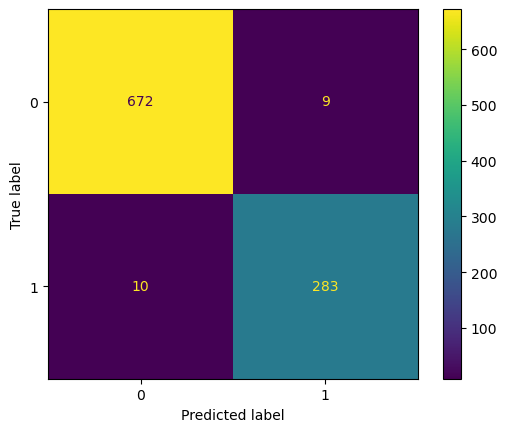

BaseTest 

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       226
           1       0.97      0.84      0.90        99

    accuracy                           0.94       325
   macro avg       0.95      0.91      0.93       325
weighted avg       0.94      0.94      0.94       325



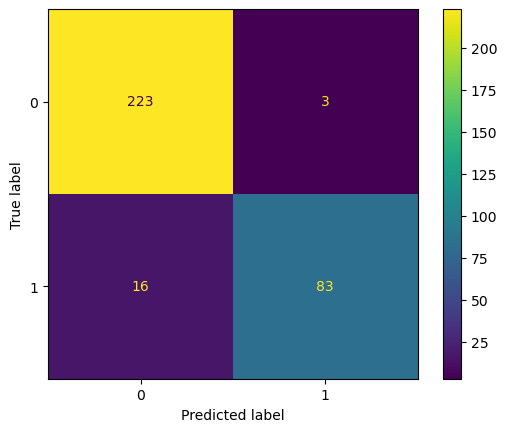

,Precision,Recall,F1 Score,Accuracy
Model Name,,,,
BaseTrain,0.969178,0.965870,0.967521,0.980493
BaseTest,0.965116,0.838384,0.897297,0.941538


In [120]:
# evaluate model
train_scores = eval_classification(y_train, train_pred, name='BaseTrain')

test_scores = eval_classification(y_test, test_pred, name='BaseTest')

base_scores = pd.concat([train_scores, test_scores])
base_scores

# Modeling: PolynomialFeatures

## Test PolynomialFeatures to see how it changes data

We are working here with the entire dataframe to illustrate how the model combines numeric features.  We won't apply the transformers until later.

In [121]:
# Scale the data
df_scaled = pd.DataFrame(scaler.fit_transform(df[['price','distance_travelled(kms)']]), 
                            columns=df[['price','distance_travelled(kms)']].columns)

# Create polynomial features
poly = PolynomialFeatures(degree=3)

poly_train = poly.fit_transform(df_scaled)
poly_train = pd.DataFrame(poly_train, columns=poly.get_feature_names_out())

poly_train

,1,price,distance_travelled(kms),price^2,price distance_travelled(kms),distance_travelled(kms)^2,price^3,price^2 distance_travelled(kms),price distance_travelled(kms)^2,distance_travelled(kms)^3
0,1.0,-0.613742,-1.823289,0.376679,1.119030,3.324384,-0.231184,-0.686796,-2.040315,-6.061313
1,1.0,-0.671885,1.275503,0.451430,-0.856992,1.626909,-0.303309,0.575800,-1.093096,2.075127
2,1.0,0.679942,0.519931,0.462321,0.353523,0.270328,0.314352,0.240375,0.183807,0.140552
3,1.0,1.578253,-0.651936,2.490883,-1.028920,0.425021,3.931244,-1.623897,0.670791,-0.277087
4,1.0,-0.584671,-0.712664,0.341840,0.416674,0.507890,-0.199864,-0.243617,-0.296948,-0.361955
...,...,...,...,...,...,...,...,...,...,...
1294,1.0,-0.308491,-3.016943,0.095167,0.930699,9.101942,-0.029358,-0.287112,-2.807866,-27.460037
1295,1.0,-0.692235,-0.135020,0.479190,0.093465,0.018230,-0.331712,-0.064700,-0.012620,-0.002461
1296,1.0,3.499883,-0.201768,12.249181,-0.706165,0.040710,42.870702,-2.471494,0.142481,-0.008214
1297,1.0,-0.753286,1.496937,0.567439,-1.127621,2.240821,-0.427444,0.849421,-1.687979,3.354369


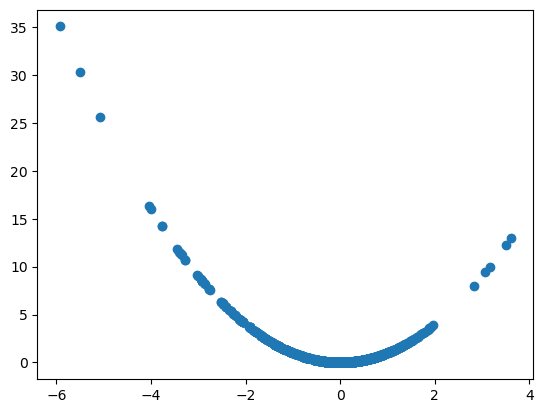

In [122]:
# Plot distance vs distance^2
plt.scatter(data=poly_train, x='distance_travelled(kms)', y='distance_travelled(kms)^2')

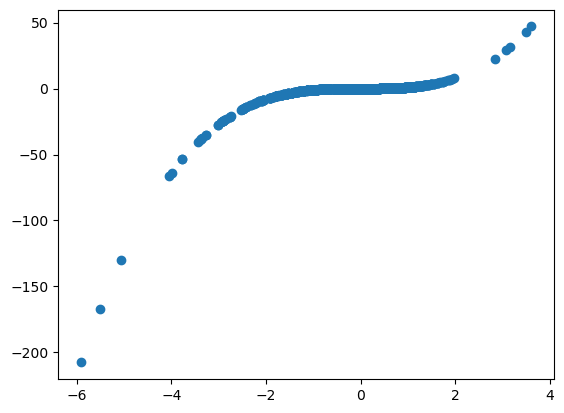

In [123]:
# Plot distance vs distance^2
plt.scatter(data=poly_train, x='distance_travelled(kms)', y='distance_travelled(kms)^3')

## Model with PolynomialFeatures

In [124]:
# instantiate transformers
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
# Instantiate the PolynomialFeatures transformer
poly = PolynomialFeatures(degree=2)

cat_cols = make_column_selector(dtype_include='object')
num_cols = make_column_selector(dtype_include='number')

# Add the PolynomialFeatures transformer to the numeric pipeline
num_pipe = make_pipeline(scaler, poly)

# create preprocessing pipeline
preprocess = make_column_transformer((ohe, cat_cols), (num_pipe, num_cols))

# Examine the results of all transformers
preprocess.fit_transform(X_train, y_train).shape

(974, 838)

In [125]:
# Create and evaluate model with PolynomialFeatures
poly_logreg = LogisticRegression(max_iter=1000)
poly_logreg = make_pipeline(preprocess, poly_logreg)
poly_logreg.fit(X_train, y_train)

train_pred = poly_logreg.predict(X_train)
test_pred = poly_logreg.predict(X_test)

PolyTrain 

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       681
           1       0.97      0.96      0.96       293

    accuracy                           0.98       974
   macro avg       0.98      0.97      0.97       974
weighted avg       0.98      0.98      0.98       974



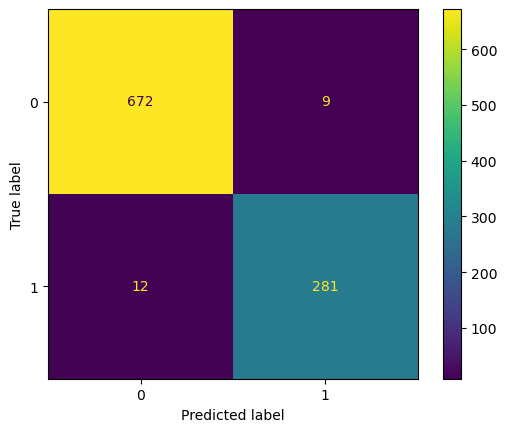

PolyTest 

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       226
           1       0.98      0.85      0.91        99

    accuracy                           0.95       325
   macro avg       0.96      0.92      0.94       325
weighted avg       0.95      0.95      0.95       325



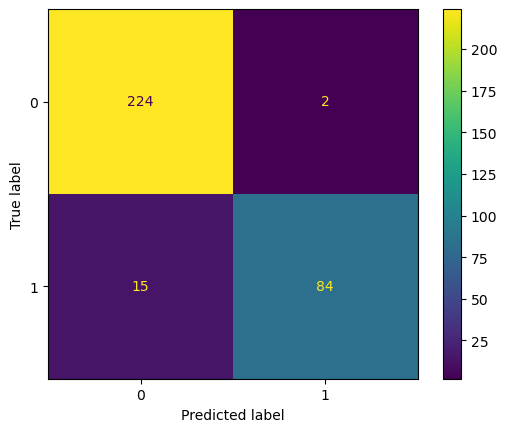

,Precision,Recall,F1 Score,Accuracy
Model Name,,,,
PolyTrain,0.968966,0.959044,0.963979,0.978439
PolyTest,0.976744,0.848485,0.908108,0.947692


In [126]:
# evaluate model
train_scores = eval_classification(y_train, train_pred, name='PolyTrain')

test_scores = eval_classification(y_test, test_pred, name='PolyTest')

poly_scores = pd.concat([train_scores, test_scores])
poly_scores

## Compare base and polynomial model scores

In [127]:
pd.concat([base_scores, poly_scores])

,Precision,Recall,F1 Score,Accuracy
Model Name,,,,
BaseTrain,0.969178,0.965870,0.967521,0.980493
BaseTest,0.965116,0.838384,0.897297,0.941538
PolyTrain,0.968966,0.959044,0.963979,0.978439
PolyTest,0.976744,0.848485,0.908108,0.947692


## What if we change the degree?